## Section 1: Download and import the required libraries and packages

In [2]:
# Cell 1: All necessary imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms
                                               
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import random

import kagglehub
import os
import urllib.request
import pathlib

import os
import shutil
import pandas as pd

## Section 2: Download the dataset from https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university

In [ ]:
# Download the dataset - Chest X-rays (IU)
# Download latest version


%pip install --upgrade kagglehub

# Get current working directory
parent_dir = pathlib.Path(os.getcwd())

# Define the path to the data directory
data_dir = parent_dir / "Data"

# Create the data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the dataset from Kaggle
# If you cannot download the dataset from Kaggle, you can go and check this website:https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university", path=data_dir)
print("Path to dataset files:", path)

## Section 3: Release GPU Memory

In [3]:
import torch
import gc

# Check and realease GPU memory
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            print(type(obj), obj.size()) 
    except:
        pass

my_tensor = torch.randn(1000, 1000).cuda()  
del my_tensor  
gc.collect()  
torch.cuda.empty_cache()  

c:\Users\Chris\anaconda3\envs\NEU_CSYE_7374_GPU\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
C:\Users\Chris\AppData\Local\Temp\ipykernel_31308\3755095164.py:7: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):


<class 'torch.Tensor'> torch.Size([])


## Section 4: Data Curation

In [ ]:
def classify_xray_images(image_dir, excel_file, output_dir):
    """
    Based on the projection information provided in the excel file,
    classify the X-ray images into "Frontal" and "Lateral" directories.

    Args:
        image_dir (str): the location of the Chest X-ray images.
        excel_file (str): the csv file containing projection information.
        output_dir (str): output directory to save Classified Images.
    """

    # Read Excel file ("indiana_projections")
    df = pd.read_csv(excel_file)

    # Classify images based on projection information that provided in the excel file
    # Create output directories for Frontal and Lateral images
    frontal_dir = os.path.join(output_dir, "Frontal")
    lateral_dir = os.path.join(output_dir, "Lateral")
    os.makedirs(frontal_dir, exist_ok=True)
    os.makedirs(lateral_dir, exist_ok=True)

    # Traver every row in the Excel file
    for index, row in df.iterrows():
        # Store the image name under the "filename" column
        image_name = row["filename"]  
        # Store the projection information under the "projection" column
        projection = row["projection"]

        image_path = os.path.join(image_dir, image_name)

        # According to the projection information, copy the image to the corresponding directory
        if projection == "Frontal":
            shutil.copy(image_path, os.path.join(frontal_dir, image_name))
        elif projection == "Lateral":
            shutil.copy(image_path, os.path.join(lateral_dir, image_name))

# Get current working directory
parent_dir = pathlib.Path(os.getcwd())

# Define the path to the images and csv file
image_directory = parent_dir / "Data" / "chest-xrays-indiana-university" / "images"  
excel_filepath = parent_dir / "Data" / "chest-xrays-indiana-university" / "indiana_projections.csv"
output_directory = parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images"

# Call the function to classify images into Frontal and Lateral directories
classify_xray_images(image_directory, excel_filepath, output_directory)

In [5]:
parent_dir = pathlib.Path(os.getcwd())

## Section 5: Extract the Descriptions and Uid from the CSV file

In [6]:
def description_of_images(excel_file):
    """
    This function provides a description of the images in the dataset.

    Args:
        excel_file (str): the csv file containing information about images.

    Returns:
        list: A list of tuples, where each tuple contains (uid, description).
    """


    # A tuple list to store the (uid, description) pairs
    description_tuples = []
    # A tuple list to store the (uid, description) pairs


    # Read Excel file ("indiana_projections")
    df = pd.read_csv(excel_file)

    def create_description_tuple(row):
        """According to csv file build up (uid, description) tuples。"""
        uid = row['uid'] 
        description_parts = []

        if pd.notna(row['MeSH']):
            description_parts.append(f"MeSH: {row['MeSH']}.")

        if pd.notna(row['Problems']):
            description_parts.append(f"Problems: {row['Problems']}.")

        if pd.notna(row['image']):
            description_parts.append(f"Image: {row['image']}.")

        if pd.notna(row['indication']):
            description_parts.append(f"Indication: {row['indication']}.")

        if pd.notna(row['comparison']):
            description_parts.append(f"comparison: {row['comparison']}.")

        if pd.notna(row['findings']):
            description_parts.append(f"Findings: {row['findings']}.")

        if pd.notna(row['impression']):
            description_parts.append(f"Impression: {row['impression']}.")

        description = " ".join(description_parts)  
        return (uid, description)

    description_tuples = df.apply(create_description_tuple, axis=1).tolist()
    print(f"Total number of descriptions: {len(description_tuples)}")

    # print(description_tuples)
    return description_tuples

    
excel_filepath_2 = parent_dir / "Data" / "chest-xrays-indiana-university" / "indiana_reports.csv"
description_data = description_of_images(excel_filepath_2)

# Convert the list of tuples to a DataFrame
df_descriptions = pd.DataFrame(description_data, columns=['uid', 'description'])

# Save the DataFrame to a CSV file
output_csv_path = os.path.join(parent_dir / "Data" / "chest-xrays-indiana-university", "image_descriptions.csv")
df_descriptions.to_csv(output_csv_path, index=False)


Total number of descriptions: 3851


## Section 6: Dataset and Dataloader

In [7]:
import os
import random
import torch
from torch.utils.data import Dataset, Subset
from torchvision import transforms
from PIL import Image
import pandas as pd
from transformers import AutoTokenizer, AutoModel

class ChestXrayDataset(Dataset):
    """Dataset class for loading paired/unpaired Frontal-Lateral X-ray data (PNG)."""

    def __init__(self, frontal_dir, lateral_dir, excel_file, paired=True, transform=None, cache_size=0, max_length=128, embedding_dim=128):
        """
        Args:
            frontal_dir (str): Directory containing Frontal X-ray images.
            lateral_dir (str): Directory containing Lateral X-ray images.
            excel_file(str): csv file containing image descriptions.
            paired (bool): If True, uses paired Frontal-Lateral data, else random unpaired selection.
            transform: Optional transforms to apply to images.
            cache_size (int): Number of images to cache in memory (0 for no caching).
            max_length (int): max length of the description.
        """
        super().__init__()
        self.max_length = max_length
        # Add resize transform
        self.resize_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

        # Store initialization parameters
        self.frontal_dir = frontal_dir
        self.lateral_dir = lateral_dir
        self.excel_file = excel_file
        self.transform = transform
        self.paired = paired
        self.cache_size = cache_size
        self.embedding_dim = embedding_dim
        self.embedding_reducer = nn.Linear(312, embedding_dim)

        # Get lists of all PNG files
        self.frontal_files = sorted([f for f in os.listdir(frontal_dir) if f.endswith('.png')])
        self.lateral_files = sorted([f for f in os.listdir(lateral_dir) if f.endswith('.png')])
        print(f"Found {len(self.frontal_files)} Frontal images and {len(self.lateral_files)} Lateral images")


        # Load descriptions from CSV and create a UID-to-description mapping
        self.uid_to_description = self.load_uid_descriptions(excel_file)

        # For paired training, find matching Frontal-Lateral pairs based on filename prefix
        if self.paired:
            self.paired_files = []
            for frontal_f in self.frontal_files:
                prefix = frontal_f.split('_')[0]  # Extract the prefix (e.g., "1")
                matching_lateral = [lateral_f for lateral_f in self.lateral_files if lateral_f.split('_')[0] == prefix]
                if matching_lateral:
                    description = self.uid_to_description.get(prefix, None)
                    if description:
                        self.paired_files.append((frontal_f, matching_lateral[0], description))
                    else:
                        print(f"Warning: Description not found for UID {prefix}")
            print(f"Found {len(self.paired_files)} paired Frontal/Lateral datasets with descriptions")
            self.data_files = self.paired_files


            # -------------------------------- Check the paired files list -------------------------------- #
            # Check the paired files, and check if the description is matched with the images
            # print(self.paired_files[0])
            # -------------------------------- Check the paired files list -------------------------------- #


        else:
            # For unpaired, just use Frontal files and randomly select Lateral later
            self.data_files = [(frontal_f, None, None) for frontal_f in self.frontal_files]

        # Initialize cache dictionary
        self.cache = {}

        # Load descriptions from CSV
        self.descriptions = self.load_uid_descriptions(excel_file)

        # Choose a model name for the tokenizer and text encoder
        # model_name = "openai/clip-vit-base-patch32"
        # model_name = "bert-base-uncased" # Embedding Dimension size: 768
        # model_name = "distilbert-base-uncased" # Embedding Dimension size: 768
        model_name = "huawei-noah/TinyBERT_General_4L_312D" # Embedding Dimension size: 312

        # Load tokenizer and text encoder based on model name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) 
        self.text_encoder = AutoModel.from_pretrained(model_name) 

    def load_uid_descriptions(self, excel_file):
        """Loads descriptions from CSV and returns a dictionary of UID to description."""
        df = pd.read_csv(excel_file)
        uid_to_description = dict(zip(df['uid'].astype(str), df['description']))
        return uid_to_description

    def _load_and_validate_image(self, filename, is_frontal=True):
        """Load and validate a single PNG image."""
        dir_path = self.frontal_dir if is_frontal else self.lateral_dir
        filepath = os.path.join(dir_path, filename)

        # Check if image is in cache
        if filepath in self.cache:
            img = self.cache[filepath]
        else:
            # Load image using PIL
            # Convert PNG file to PIL Image
            img = Image.open(filepath).convert('L')  # Convert to grayscale

            # Validate image (optional: add more complex validation if needed)
            if img is None:
                raise ValueError(f"Invalid image: {filename}")

            # Cache image if cache isn't full
            if len(self.cache) < self.cache_size:
                self.cache[filepath] = img

        return img

    def __len__(self):
        """Return the total number of Frontal-Lateral pairs in the dataset."""
        return len(self.data_files)

    def __getitem__(self, idx):
        """Get a Frontal-Lateral pair of images."""
        frontal_file, lateral_file, description = self.data_files[idx]

        # Load Frontal image
        frontal_img = self._load_and_validate_image(frontal_file, is_frontal=True)

        if self.paired:
            # Load matching Lateral image for paired data
            lateral_img = self._load_and_validate_image(lateral_file, is_frontal=False)
        else:
            # For unpaired data, randomly select a Lateral image
            random_lateral_idx = random.randint(0, len(self.lateral_files) - 1)
            lateral_img = self._load_and_validate_image(self.lateral_files[random_lateral_idx], is_frontal=False)

        # Convert images to tensors (from PIL to tensor) and apply resize transform
        frontal_tensor = self.resize_transform(frontal_img)
        lateral_tensor = self.resize_transform(lateral_img)

        if self.transform:
            frontal_tensor = self.transform(frontal_tensor)
            lateral_tensor = self.transform(lateral_tensor)

        # Convert description to tensor
        inputs = self.tokenizer(description, padding='max_length', max_length=self.max_length, truncation=True, return_tensors='pt')
        description_tensor = self.text_encoder(inputs.input_ids, attention_mask=inputs.attention_mask).last_hidden_state.squeeze(0).unsqueeze(0)
        description_tensor = self.embedding_reducer(description_tensor)

        # Clean up images if not cached
        if frontal_file not in self.cache:
            del frontal_img
        if lateral_file not in self.cache:
            del lateral_img

        return {'Frontal': frontal_tensor, 'Lateral': lateral_tensor, 'Description': description_tensor}

# Utilize the new csv file with concatenated descriptions and uids
excel_file_3 = parent_dir / "Data" / "chest-xrays-indiana-university" / "image_descriptions.csv"
frontal_dir = parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Frontal"
lateral_dir = parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Lateral"

dataset = ChestXrayDataset(
    frontal_dir=frontal_dir,
    lateral_dir=lateral_dir,
    # "image_descriptions.csv"
    excel_file=excel_file_3,
    paired=True
)

print(f"The length of dataset (list of dictionaries): {len(dataset)}")
sample = dataset[0]

print("Sample:")
print("Frontal Tensor:", sample['Frontal'].shape)
print("Lateral Tensor:", sample['Lateral'].shape)
print("Description Tensor:", sample['Description'].shape)
print(sample['Description'])



Found 3818 Frontal images and 3648 Lateral images
Found 3510 paired Frontal/Lateral datasets with descriptions
The length of dataset (list of dictionaries): 3510
Sample:
Frontal Tensor: torch.Size([1, 128, 128])
Lateral Tensor: torch.Size([1, 128, 128])
Description Tensor: torch.Size([1, 128, 128])
tensor([[[-0.1275, -0.0629,  0.2173,  ...,  0.2361,  0.0162,  0.1035],
         [ 0.0713, -0.1244,  0.4351,  ..., -0.0629,  0.1343,  0.5295],
         [-0.3153, -0.1129,  0.3881,  ..., -0.3742,  0.0163,  0.5584],
         ...,
         [ 0.0474, -0.0742,  0.0196,  ..., -0.1535, -0.1162,  0.5974],
         [-0.1079,  0.0751,  0.2203,  ..., -0.0727, -0.0602,  0.5006],
         [-0.1516,  0.0497,  0.1704,  ..., -0.1986,  0.0211,  0.4371]]],
       grad_fn=<ViewBackward0>)


## Section 7: Model (U-net Model for denoising process)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define an Identity module to bypass attention when not used.
class Identity(nn.Module):
    def forward(self, x, *args, **kwargs):
        return x

# Inherit from nn.Module to create a custom TimeEmbedding class.
# nn = torch.nn = torch.neuralnetwork
class TimeEmbedding(nn.Module):
    """Projects timesteps into a higher-dimensional space for time conditioning."""
    # Constructor takes the number of channels as an argument.
    def __init__(self, n_channels):
        # Call the parent constructor to initialize the module.
        # super() is a built-in function that returns a temporary object of the superclass.
        super().__init__()
        # Define data fields for the number of channels and the time projection layers.
        self.n_channels = n_channels
        # Define data fields for the time projection layers.
        self.time_proj = nn.Sequential(
            # Linear layer to project the input time step to the number of channels.
            nn.Linear(1, n_channels),
            # Activation function to introduce non-linearity.
            nn.SiLU(),
            # Linear layer to project the output of the activation function back to the number of channels.
            nn.Linear(n_channels, n_channels)
        )
    # Forward propagation method to define the forward pass of the module.
    # Takes the input time step as an argument.
    def forward(self, t):
        # t: [B] -> [B, 1]
        # Convert the input time step to a 2D tensor with shape [B, 1] by unsqueezing the last dimension.
        t = t.unsqueeze(-1).float()
        return self.time_proj(t)  # [B, n_channels]

class ConvBlock(nn.Module):
    """A convolutional block with time conditioning and residual connections."""
    def __init__(self, in_channels, out_channels, time_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.time_mlp = nn.Linear(time_channels, out_channels)
        # Residual connection
        self.use_residual = in_channels == out_channels
        if not self.use_residual:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)
    def forward(self, x, t):
        residual = x if self.use_residual else self.residual_conv(x)
        h = self.conv1(x)
        h = self.norm1(h)
        # Broadcast time embedding over spatial dimensions.
        h += self.time_mlp(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        return h + residual

class SelfAttention(nn.Module):
    """Self-attention module to capture long-range dependencies."""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
    def forward(self, x):
        # x: [B, C, H, W] -> flatten spatial dims -> [B, HW, C]
        size = x.shape[-2:]
        x_flat = x.flatten(2).transpose(1, 2)
        x_norm = self.ln(x_flat)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm)
        attn_out = attn_out + x_flat  # Skip connection
        ff_out = self.ff_self(attn_out) + attn_out
        # Restore spatial dims.
        return ff_out.transpose(1, 2).view(-1, self.channels, *size)

class CrossAttention(nn.Module):
    """Cross-attention module to attend between source and context features."""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_cross = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
    def forward(self, x, context):
        # x (query) and context (key/value) both: [B, C, H, W]
        size = x.shape[-2:]
        x_flat = x.flatten(2).transpose(1, 2)
        context_flat = context.flatten(2).transpose(1, 2)
        x_norm = self.ln(x_flat)
        attn_out, _ = self.mha(x_norm, context_flat, context_flat)
        attn_out = attn_out + x_flat  # Skip connection
        ff_out = self.ff_cross(attn_out) + attn_out
        return ff_out.transpose(1, 2).view(-1, self.channels, *size)

class UNet(nn.Module):
    """U-Net with optional self-attention and cross-attention for diffusion models."""
    def __init__(
        self,
        in_channels=3,
        # Convert time steps information to a higher-dimensional space (time embedding), you can try 256, 512 and so on......
        # Dimension of the time embedding vector.
        time_channels=256,
        n_channels=64,
        use_self_attention=True,
        use_cross_attention=True
    ):
        """
        Args:
            in_channels (int): Number of input channels.
            time_channels (int): Dimension of time embedding.
            n_channels (int): Base number of channels.
            use_self_attention (bool): If True, apply self-attention.
            use_cross_attention (bool): If True, apply cross-attention in bottleneck.
        """
        super().__init__()
        
        self.use_cross_attention = use_cross_attention
        # Context projection (only matters if using cross-attention)
        self.context_proj = nn.Conv2d(1, n_channels * 8, kernel_size=1) if use_cross_attention else Identity()
        
        # Time embedding
        self.time_embed = TimeEmbedding(time_channels)
        
        # Encoder path
        self.inc = ConvBlock(in_channels, n_channels, time_channels)
        self.down1 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels, n_channels*2, time_channels),
            SelfAttention(n_channels*2) if use_self_attention else Identity()
        ])
        self.down2 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels*2, n_channels*4, time_channels),
            SelfAttention(n_channels*4) if use_self_attention else Identity()
        ])
        self.down3 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels*4, n_channels*8, time_channels),
            SelfAttention(n_channels*8) if use_self_attention else Identity()
        ])
        
        # Bottleneck with attention
        self.bot1 = ConvBlock(n_channels*8, n_channels*8, time_channels)
        self.bot_attn = SelfAttention(n_channels*8) if use_self_attention else Identity()
        self.cross_attn = CrossAttention(n_channels*8) if use_cross_attention else Identity()
        self.bot2 = ConvBlock(n_channels*8, n_channels*8, time_channels)
        self.bot3 = ConvBlock(n_channels*8, n_channels*8, time_channels)
        
        # Decoder path with skip connections
        self.up1 = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(n_channels*12, n_channels*4, time_channels),  # Concatenation: x4 (n_channels*8) and x3 (n_channels*4)
            SelfAttention(n_channels*4) if use_self_attention else Identity()
        ])
        self.up2 = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(n_channels*6, n_channels*2, time_channels),   # Concatenation: previous output (n_channels*4) with x2 (n_channels*2)
            SelfAttention(n_channels*2) if use_self_attention else Identity()
        ])
        self.up3 = nn.ModuleList([
            ConvBlock(n_channels*3, n_channels, time_channels)        # Concatenation: previous output (n_channels*2) with x1 (n_channels)
        ])
        
        # Output convolution
        self.outc = nn.Conv2d(n_channels, 1, 1)
    
    def forward(self, x, t, condition=None, context=None):
        """
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W].
            t (torch.Tensor): Timesteps [B].
            condition (torch.Tensor, optional): Conditioning image.
            context (torch.Tensor, optional): Context image for cross-attention [B, 1, H, W].
            
        Returns:
            torch.Tensor: Output tensor [B, 1, H, W].
        """
        # Add conditioning channel if provided.
        if condition is not None:
            condition = condition.expand(-1, 1, x.shape[2], x.shape[3])
            x = torch.cat([x, condition], dim=1)
        
        # Time embedding
        t_emb = self.time_embed(t)
        
        # Encoder
        x1 = self.inc(x, t_emb)
        x2 = self.down1[0](x1)  # MaxPool2d
        x2 = self.down1[1](x2, t_emb)
        x2 = self.down1[2](x2)
        
        x3 = self.down2[0](x2)
        x3 = self.down2[1](x3, t_emb)
        x3 = self.down2[2](x3)
        
        x4 = self.down3[0](x3)
        x4 = self.down3[1](x4, t_emb)
        x4 = self.down3[2](x4)
        
        # Bottleneck
        x4 = self.bot1(x4, t_emb)
        x4 = self.bot_attn(x4)
        if context is not None:
            # Project context to match bottleneck dimensions
            context_proj = self.context_proj(context)
            x4 = self.cross_attn(x4, context_proj)
        x4 = self.bot2(x4, t_emb)
        x4 = self.bot3(x4, t_emb)
        
        # Decoder
        # Upsample x4 to match spatial dims of x3
        x4 = F.interpolate(x4, size=x3.shape[-2:], mode='bilinear', align_corners=True)
        # Concatenate x4(output of the bottleneck) with x3(output of the third downsampling block from the encoder)
        # Skip connection: Concatenate x4 with x3
        x = torch.cat([x4, x3], dim=1)
        x = self.up1[0](x)
        x = self.up1[1](x, t_emb)
        x = self.up1[2](x)
        
        x = torch.cat([x, x2], dim=1)
        x = self.up2[0](x)
        x = self.up2[1](x, t_emb)
        x = self.up2[2](x)
        
        x = torch.cat([x, x1], dim=1)
        x = self.up3[0](x, t_emb)
        
        return self.outc(x)


## Section 8: Diffusion Process

In [ ]:
class DDPMTrainer:
    """Denoising Diffusion Probabilistic Models (DDPM) Trainer.
    Handles the training process, including:
    - Forward/reverse diffusion processes
    - Optimization
    - Mixed precision training
    - Sampling
    """
    
    def __init__(
        self, model, n_timesteps=1000, beta_start=1e-4, beta_end=0.02,
        lr=1e-4, device="cuda"
    ):
        """
        Args:
            model: UNet model instance
            n_timesteps (int): Number of diffusion timesteps
            beta_start (float): Starting noise schedule value
            beta_end (float): Ending noise schedule value
            lr (float): Learning rate for Adam optimizer
            device (str): Device to run on ("cuda" or "cpu")
        """
        self.model = model.to(device)
        self.device = device
        self.n_timesteps = n_timesteps
        
        # Setup noise schedule
        self.betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Pre-compute values for diffusion process
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        
        # Setup optimizer
        self.optimizer = Adam(self.model.parameters(), lr=lr)

    def diffuse_step(self, x_0, t):
        """Forward diffusion step: adds noise to image according to timestep.
        
        Args:
            x_0 (torch.Tensor): Original clean image
            t (torch.Tensor): Timesteps for batch
            
        Returns:
            tuple: (noisy image, noise added)
        """
        noise = torch.randn_like(x_0)  # Random noise
        
        # Get noise scaling factors for timestep t
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        
        # Apply forward diffusion equation
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        return x_t, noise
    
    def train_one_batch(self, x_0, condition=None, context=None):
        """Trains model on a single batch.
        
        Args:
            x_0 (torch.Tensor): Clean images [B, C, H, W]
            condition (torch.Tensor, optional): Conditioning information
            context (torch.Tensor, optional): Context for cross-attention
            
        Returns:
            float: Batch loss value
        """
        batch_size = x_0.shape[0]
        # Sample random timesteps for batch
        t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device)
        
        # Apply forward diffusion
        x_t, noise = self.diffuse_step(x_0, t)

        # Forward pass (removed autocast since it's not supported on MPS)
        noise_pred = self.model(x_t, t, condition=condition, context=context)
        # Calculate loss between predicted and actual noise
        loss = F.mse_loss(noise_pred, noise)
        
        # Optimizer step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    @torch.no_grad()
    def sample(self, condition=None, context=None, shape=None, n_steps=None):
        """Generates samples using the reverse diffusion process.
        
        Args:
            condition (torch.Tensor, optional): Conditioning information
            context (torch.Tensor, optional): Context for cross-attention
            shape (tuple): Shape of samples to generate
            n_steps (int, optional): Number of sampling steps
            
        Returns:
            torch.Tensor: Generated samples
        """
        if n_steps is None:
            n_steps = self.n_timesteps
        
        # Start from pure noise
        x_t = torch.randn(shape, device=self.device)
        
        # Gradually denoise the sample
        for t in reversed(range(n_steps)):
            t_batch = torch.ones(shape[0], device=self.device, dtype=torch.long) * t
            
            # Predict noise in current sample
            noise_pred = self.model(x_t, t_batch, condition=condition, context=context)
            
            # Get diffusion parameters for timestep t
            alpha_t = self.alphas[t]
            alpha_t_cumprod = self.alphas_cumprod[t]
            beta_t = self.betas[t]
            
            # Add noise only if not the final step
            if t > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0.
            
            # Apply reverse diffusion equation
            x_t = (1 / torch.sqrt(alpha_t)) * (
                x_t - beta_t / torch.sqrt(1 - alpha_t_cumprod) * noise_pred
            ) + torch.sqrt(beta_t) * noise
        
        return x_t


class MetricsTracker:
    """Tracks and computes various metrics during training."""
    
    def __init__(self, device):
        """
        Args:
            device: Device to run metrics computation on
        """
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.reset()
    
    def reset(self):
        """Resets all metrics for new epoch."""
        self.train_losses = []
        self.psnr_scores = []
        self.ssim_scores = []
    
    def update(self, pred, target, loss=None):
        """Updates metrics with new batch results."""
        if loss is not None:
            self.train_losses.append(loss)
        if pred is not None and target is not None:
            self.psnr_scores.append(self.psnr(pred, target).item())
            self.ssim_scores.append(self.ssim(pred, target).item())
    
    def get_metrics(self):
        """Returns average metrics for the current period."""
        return {
            'loss': np.mean(self.train_losses) if self.train_losses else 0,
            'psnr': np.mean(self.psnr_scores) if self.psnr_scores else 0,
            'ssim': np.mean(self.ssim_scores) if self.ssim_scores else 0
        }

def visualize_samples(frontal_real, lateral_real, lateral_gen, epoch, step, loss_H, PSNR, SSIM, save=True):
    """Creates visualization grid of real and generated images.
    
    Args:
        frontal_real, lateral_real: Real frontal images and lateral images
        lateral_gen: Generated lateral images
        epoch (int): Current epoch
        step (int): Current step
        save (bool): Whether to save the plot
        loss_H (list): Training loss history
        PSNR (float): Peak Signal-to-Noise Ratio of generated image
        SSIM (float): Structural Similarity Index of generated image
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    
    # Real T1
    axes[0].imshow(frontal_real[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[0].set_title('Frontal Image (Real)')
    axes[0].axis('off')
    
    # Generated T2 from T1
    axes[2].imshow(lateral_gen[0, 0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[2].set_title(f'Sampled Lateral Image\nPSNR: {PSNR:.4f}, SSIM: {SSIM:.4f}')
    axes[2].axis('off')

    # Real T2
    axes[1].imshow(lateral_real[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[1].set_title('Lateral Image (Real)')
    axes[1].axis('off')

    # Loss Curve
    axes[3].plot(loss_H)
    axes[3].set_title('Training Loss (MSE)')
    axes[3].set_xlabel('Steps')
    axes[3].set_ylabel('Loss')
    
    
    
    plt.tight_layout()
    
    if save:
        # Save the images during training process
        # You can alter the path to save the images in your local machine
        # Down here is the configuration on my local machine
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
        plt.savefig(f'E:/NEU_CSYE_7374/Final_Project/Visualizations/Diffusion_WithAttention/WithAttention_samples_epoch{epoch}_step{step}.png')
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
        plt.close()
    else:
        plt.show()

## Section 9: Training Loop Script

In [ ]:
class Config:
    """Configuration class containing all training parameters and paths."""
    def __init__(self):
        # Data paths
        self.frontal_dir = parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Frontal"
        self.lateral_dir = parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Lateral"
        self.excel_file = parent_dir / "Data" / "chest-xrays-indiana-university" / "image_descriptions.csv"
        
        # Model parameters
        self.in_channels = 2  # Image + condition channel
        self.time_channels = 256
        self.n_channels = 64
        self.n_timesteps = 300
        self.beta_start = 1e-4
        self.beta_end = 0.02
        
        # Training parameters
        self.batch_size = 1
    
        self.num_epochs = 80
        self.lr = 1e-4
        self.save_interval = 100  # Save checkpoints every N steps
        
        # Save the checkpoints, you will need to alter the path to save the checkpoints in your local machine
        # In the text validation part, you will need to load the checkpoints from the path you save in order to validate the model
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
        self.checkpoint_dir = Path("E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention")
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #


        # Save the visualizations and log, you will need to alter the path to save the visualizations in your local machine
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
        self.vis_dir = Path("E:/NEU_CSYE_7374/Final_Project/Visualizations/Diffusion_WithAttention") 
        self.log_dir = Path("E:/NEU_CSYE_7374/Final_Project/Logs/Diffusion_WithAttention")
        # -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
        
        # Create directories if they don't exist
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.vis_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Device
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize configuration
config = Config()

# Cell 8: Training Functions

def load_checkpoint(trainer, checkpoint_path):
    """Loads model and optimizer state from checkpoint.
    
    Args:
        trainer: DDPMTrainer instance
        checkpoint_path: Path to checkpoint file
        
    Returns:
        tuple: (epoch, global_step)
    """
    checkpoint = torch.load(checkpoint_path)
    trainer.model.load_state_dict(checkpoint['model_state_dict'])
    trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['global_step']

def save_checkpoint(trainer, epoch, global_step):
    """Saves model and optimizer state to checkpoint.
    
    Args:
        trainer: DDPMTrainer instance
        epoch: Current epoch
        global_step: Current global step
    """
    checkpoint = {
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'epoch': epoch,
        'global_step': global_step,
    }
    torch.save(checkpoint, 
               config.checkpoint_dir / f'model_epoch{epoch}_step{global_step}.pt')

# Main Training Loop

def train_diffusion():
    """Main training function that handles the complete training pipeline."""
    
    # Initialize tensorboard writer
    writer = SummaryWriter(config.log_dir)
    
    # Initialize dataset and dataloader
    # dataset = ChestXrayDataset(
    #     frontal_dir=frontal_dir,
    #     lateral_dir=lateral_dir,
    #     excel_file=excel_file_3,
    #     paired=True
    # )


    Full_dataset = ChestXrayDataset(
        frontal_dir=config.frontal_dir,
        lateral_dir=config.lateral_dir,
        excel_file=config.excel_file,
        paired=True
    )
    

    #
    Train_size = 1000
    Train_dataset = Subset(Full_dataset, range(Train_size))
    Val_dataset = Subset(Full_dataset, range(Train_size, 1050))
    
    Train_dataloader = DataLoader(
        Train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )

    # Initialize model and trainer
    # model = UNet(
    #     in_channels=config.in_channels,
    #     time_channels=config.time_channels,
    #     n_channels=config.n_channels,
    #     use_self_attention=False,
    #     use_cross_attention=False,
    # )

    model = UNet(
        in_channels=config.in_channels,
        time_channels=config.time_channels,
        n_channels=config.n_channels,
        use_self_attention=True,
        use_cross_attention=True,
    )
    
    trainer = DDPMTrainer(
        model=model,
        n_timesteps=config.n_timesteps,
        beta_start=config.beta_start,
        beta_end=config.beta_end,
        lr=config.lr,
        device=config.device
    )
    
    # Initialize metrics tracker
    metrics = MetricsTracker(config.device)
    loss_H = []
    # Check for existing checkpoint
    start_epoch = 0
    global_step = 0
    if config.checkpoint_dir.exists():
        checkpoints = list(config.checkpoint_dir.glob('model_epoch*_step*.pt'))
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=os.path.getctime)
            # Load checkpoint with weights_only=True to avoid security warning
            start_epoch, global_step = load_checkpoint(trainer, latest_checkpoint)
            print(f"Resuming from epoch {start_epoch}, step {global_step}")
    
    # Training loop
    for epoch in range(start_epoch, config.num_epochs):
        metrics.reset()
        epoch_pbar = tqdm(Train_dataloader, desc=f"Epoch {epoch}")
        
        for batch_idx, batch in enumerate(epoch_pbar):
            # Move data to device
            frontal = batch['Frontal'].to(config.device)
            lateral = batch['Lateral'].to(config.device)
            description = batch['Description'].to(config.device)
            # Train Description -> lateral
            loss_Description_Lateral = trainer.train_one_batch(
                x_0=lateral,                # Target is lateral image
                condition=description,      # Condition on Description
                context=frontal             # Cross-attention sees Frontal image
            )
            
            # # Train T2 -> T1
            # loss_Description_Lateral = trainer.train_one_batch(
            #     x_0=t1,            # Target is T1
            #     condition=t2,      # Condition on T2
            #     context=t2         # Cross-attention sees T2
            # )
            
            # Update metrics
            loss = loss_Description_Lateral
            metrics.update(None, None, loss)
            loss_H.append(loss)

            
            # Update progress bar
            epoch_pbar.set_postfix({
                'loss': f"{loss:.4f}",
                'step': global_step
            })
            
            # Checkpoint and visualization
            if global_step % config.save_interval == 0:
                trainer.model.eval()
                with torch.no_grad():
                    # Generate samples
                    lateral_gen = trainer.sample(
                        condition=description,
                        context=frontal,
                        shape=frontal.shape
                    )

                    # t1_gen = trainer.sample(
                    #     condition=t2,
                    #     context=t2,
                    #     shape=t2.shape
                    # )
                    
                    # Calculate metrics for generated images
                    metrics.update(lateral_gen, lateral)
                    # metrics.update(t1_gen, t1)
                    

                    # Log to tensorboard
                    current_metrics = metrics.get_metrics()
                    writer.add_scalar('Loss/train', current_metrics['loss'], global_step)
                    writer.add_scalar('Metrics/PSNR', current_metrics['psnr'], global_step)
                    writer.add_scalar('Metrics/SSIM', current_metrics['ssim'], global_step)
                    writer.add_images('Samples/Frontal', frontal, global_step)
                    writer.add_images('Samples/Lateral', lateral, global_step)
                    # writer.add_images('Samples/T1_generated', t1_gen, global_step)
                    writer.add_images('Samples/Lateral_generated', lateral_gen, global_step)
                    
                    
                    # Visualize samples
                    visualize_samples(
                        frontal, lateral,
                        lateral_gen,
                        epoch, global_step,
                        loss_H,
                        current_metrics['psnr'],
                        current_metrics['ssim']
                    )
                    
                    
                    
                    # Save checkpoint
                    save_checkpoint(trainer, epoch, global_step)
                
                trainer.model.train()
            
            global_step += 1
        
        # End of epoch
        epoch_metrics = metrics.get_metrics()
        print(f"\nEpoch {epoch} Summary:")
        print(f"Average Loss: {epoch_metrics['loss']:.4f}")
        print(f"Average PSNR: {epoch_metrics['psnr']:.2f}")
        print(f"Average SSIM: {epoch_metrics['ssim']:.4f}")
    
    writer.close()


if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Start training
    train_diffusion()

Found 3818 Frontal images and 3648 Lateral images
Found 3510 paired Frontal/Lateral datasets with descriptions


C:\Users\Chris\AppData\Local\Temp\ipykernel_7376\1862254881.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming from epoch 99, step 99900


## Section 10: Validation with 50 datasets

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import transforms
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


def load_checkpoint_and_prepare_model(checkpoint_path,in_c, time_c, n_c, use_attention, device):
    """Load Learnable parameters from checkpoint and prepare model for evaluation."""
    model = UNet(
        in_channels=in_c,
        time_channels=time_c,
        n_channels=n_c,
        use_self_attention=use_attention,
        use_cross_attention=use_attention,
    ).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True) 
    model.load_state_dict(checkpoint['model_state_dict'])
    # print(model.inc.conv1.weight[0][0][0][0])
    model.eval()
    return model

def validate_model(model, n_time, beta_s, beta_e, learning_r, dataloader, device):
    """Given Val_dataloader and model."""
    """Validate the model using PSNR and SSIM metrics."""
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure().to(device)
    psnr_scores = []
    ssim_scores = []
    generated_samples = []

    # Initialize DDPMTrainer with training parameters
    trainer = DDPMTrainer(
        model=model,
        n_timesteps=n_time,
        beta_start=beta_s,
        beta_end=beta_e,
        lr=learning_r,
        device=device
    )

    with torch.no_grad():
        for batch in dataloader:
            frontal = batch['Frontal'].to(device)
            lateral_real = batch['Lateral'].to(device)
            description = batch['Description'].to(device)

            # Utilize DPMMTrainer to do the reverse diffusion process
            lateral_gen = trainer.sample(
                condition=description,
                context=description,
                shape=description.shape
            )

            # Convert generated images to the same range as real images
            lateral_gen_normalized = (lateral_gen + abs(lateral_gen.min())) / (lateral_gen.max() + abs(lateral_gen.min()))

            # Check if the range is between 0 and 1 for both generated image and the real image
            # print(f"lateral_gen min: {lateral_gen_normalized.min()}, max: {lateral_gen_normalized.max()}")
            # print(f"lateral_real min: {lateral_real.min()}, max: {lateral_real.max()}")

            psnr = psnr_metric(lateral_gen_normalized, lateral_real).item()
            ssim = ssim_metric(lateral_gen_normalized, lateral_real).item()

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)
            generated_samples.append((frontal, lateral_real, lateral_gen_normalized)) 

    # Calculate average PSNR and SSIM for all the validation samples
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)

    return avg_psnr, avg_ssim, generated_samples

def visualize_validation_samples(samples, save_path=None):
    """Visualizes generated samples from validation."""
    if save_path:
        os.makedirs(save_path, exist_ok=True) 

    for i, (frontal_real, lateral_real, lateral_gen) in enumerate(samples):
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        axes[0].imshow(frontal_real[0, 0].cpu().numpy().T, cmap='gray', origin='lower')
        axes[0].set_title('Frontal Image (Real)')
        axes[0].axis('off')

        axes[1].imshow(lateral_real[0, 0].cpu().numpy().T, cmap='gray', origin='lower')
        axes[1].set_title('Lateral Image (Real)')
        axes[1].axis('off')

        axes[2].imshow(lateral_gen[0, 0].cpu().numpy().T, cmap='gray', origin='lower')
        axes[2].set_title('Lateral Image (Generated)')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(f'{save_path}/validation_sample_{i}.png')
            plt.close()
        else:
            plt.show()

# The path to the final checkpoint file of the model:
# You need to alter the path to load the checkpoint in your local machine
# According to which epoch and step you want to load the checkpoint
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch99_step99900.pt"
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #


device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = load_checkpoint_and_prepare_model(checkpoint_with_attention, 2, 256, 64, True, device)


Full_dataset = ChestXrayDataset(
    frontal_dir=parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Frontal",
    lateral_dir=parent_dir / "Data" / "chest-xrays-indiana-university" / "Classified_Images" / "Lateral",
    excel_file=parent_dir / "Data" / "chest-xrays-indiana-university" / "image_descriptions.csv",
    paired=True
)


Train_size = 1000
# Load the training dataset to test the functions
# Train_dataset = Subset(Full_dataset, range(Train_size))

# Load the training dataset to test the functions
Val_dataset = Subset(Full_dataset, range(Train_size, 1050))

Val_dataloader = DataLoader(
    Val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

avg_psnr, avg_ssim, generated_samples = validate_model(model, 300, 1e-4, 0.02, 1e-4, Val_dataloader, device)

print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Store the generated images in specified directory
# You need to alter the path to save the images in your local machine
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
visualize_validation_samples(generated_samples, save_path="E:/NEU_CSYE_7374/Final_Project/Training_Set_6_Des & Des/Visualizations")
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
# visualize_validation_samples(generated_samples)

Device:  cuda
Found 3818 Frontal images and 3648 Lateral images
Found 3510 paired Frontal/Lateral datasets with descriptions


c:\Users\Chris\anaconda3\envs\NEU_CSYE_7374_GPU\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
c:\Users\Chris\anaconda3\envs\NEU_CSYE_7374_GPU\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Average PSNR: 7.2288
Average SSIM: 0.1765


## Section 11: Generate X-Ray Image (Lateral) by input text

Device:  cuda


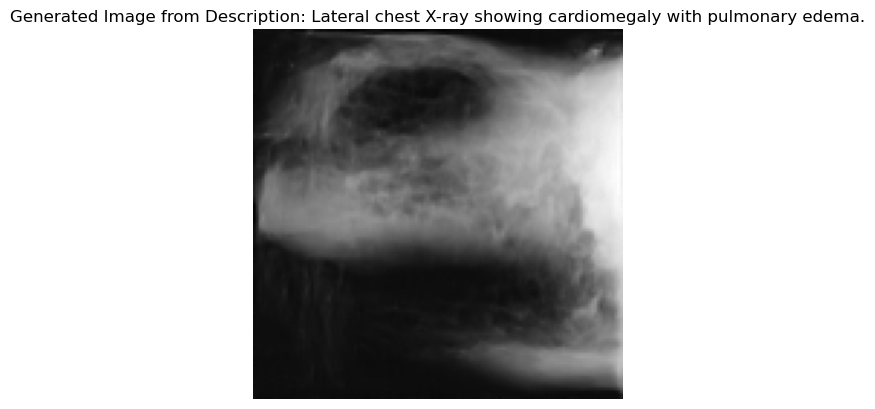

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

def load_checkpoint_and_prepare_model(checkpoint_path, in_c, time_c, n_c, use_attention, device):
    """Load Learnable parameters from checkpoint and prepare model for evaluation."""
    model = UNet(
        in_channels=in_c,
        time_channels=time_c,
        n_channels=n_c,
        use_self_attention=use_attention,
        use_cross_attention=use_attention,
    ).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def validate_model_with_description(model, n_time, beta_s, beta_e, learning_r, device, description_text):
    """Given Text (description) and model."""

    model_name = "huawei-noah/TinyBERT_General_4L_312D"  # Embedding Dimension size: 312

    # Load tokenizer and text encoder based on model name
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    text_encoder = AutoModel.from_pretrained(model_name).to(device) # move to device
    embedding_reducer = nn.Linear(312, 128).to(device) # move to device

    # Tokenize and encode the description text
    inputs = tokenizer(description_text, padding='max_length', max_length=128, truncation=True, return_tensors='pt').to(device) # move to device
    description_tensor = text_encoder(inputs.input_ids, attention_mask=inputs.attention_mask).last_hidden_state.squeeze(0).unsqueeze(0)
    description_tensor = embedding_reducer(description_tensor)

    # Check the shape of the description tensor
    # print(description_tensor.shape) 
     # Add channel dimension
    description_tensor = description_tensor.unsqueeze(1) # Add a channel dimension

    # Check the shape of the description tensor
    # print(description_tensor.shape) 

    # Initialize DDPMTrainer with training parameters
    trainer = DDPMTrainer(
        model=model,
        n_timesteps=n_time,
        beta_start=beta_s,
        beta_end=beta_e,
        lr=learning_r,
        device=device
    )

    with torch.no_grad():
        # Utilize DPMMTrainer to do the reverse diffusion process
        lateral_gen = trainer.sample(
            condition=description_tensor,
            context=description_tensor,
            shape=description_tensor.shape 
        )

        # Convert generated images to the same range as real images
        lateral_gen_normalized = (lateral_gen + abs(lateral_gen.min())) / (lateral_gen.max() + abs(lateral_gen.min()))

        return lateral_gen_normalized.squeeze(0).cpu() # return single image


# Load the model checkpoint
# You need to alter the path to load the checkpoint in your local machine
# According to which epoch and step you want to load the checkpoint
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
# checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch19_step19900.pt"
# checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch39_step39900.pt"
# checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch59_step59900.pt"
# checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch79_step79900.pt"
checkpoint_with_attention = "E:/NEU_CSYE_7374/Final_Project/Checkpoints/Diffusion_WithAttention/model_epoch99_step99900.pt"
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #


device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = load_checkpoint_and_prepare_model(checkpoint_with_attention, 2, 256, 64, True, device)


# Input the description text you want to generate the image from model you just loaded
# You need to alter the description text to generate the image you want
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #
description_text = "Lateral chest X-ray showing cardiomegaly with pulmonary edema."
# -------------------------------------------------------------------- Make Changes Here -------------------------------------------------------------------- #


generated_image = validate_model_with_description(model, 300, 1e-4, 0.02, 1e-4, device, description_text)

plt.imshow(generated_image[0].numpy().T, cmap='gray', origin='lower')
plt.title(f'Generated Image from Description: {description_text}') # Corrected line
plt.axis('off')
plt.show()